# 03__activs_general 
In this notebook, i look at activities of the sequences (Wildtype has snp, and Wildtype) compared to negative controls. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False


In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def fix_cleaner_biotype(row, biotype_col):
    try:
        if row["name"] == "RANDOM":
            return "negative control"
        elif "CONTROL" in row.name:
            return "positive control"
        else:
            return row[biotype_col]
    except:
        return row[biotype_col]

In [5]:
def is_sig(row, col):
    if row[col] < 0.05:
        return "sig"
    else:
        return "not sig"

## variables

In [6]:
data_dir = "../../../data/02_activs"
alpha_f = "%s/alpha_per_elem.quantification.CM.new_back.txt" % data_dir

In [7]:
index_f = "../../../data/design/Hypertension__pooled.index.txt"

In [8]:
mital_snps_f = "../../../data/design/name_Mital_SNPS.txt"

## 1. import files

In [9]:
alpha = pd.read_table(alpha_f, sep="\t")
alpha.reset_index(inplace=True)
alpha.head()

index        CM       CM_pval  \
0  AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...  0.243209  2.933007e-01   
1  AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...  0.495174  2.070978e-07   
2  AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...  0.197718  6.072048e-01   
3  AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...  0.233769  3.540256e-01   
4  ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...  0.242551  2.973739e-01   

    CM_padj  
0  0.861212  
1  0.000003  
2  0.861212  
3  0.861212  
4  0.861212

In [10]:
index = pd.read_table(index_f, sep="\t")

In [11]:
index.head()

element             tile_type  \
0  ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...  WILDTYPE_BUT_HAS_SNP   
1  ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...  WILDTYPE_BUT_HAS_SNP   
2  ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...  WILDTYPE_BUT_HAS_SNP   
3  ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...  WILDTYPE_BUT_HAS_SNP   
4  ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...  WILDTYPE_BUT_HAS_SNP   

         tile_id                                               name  \
0  1.1.0.0.0.0.1  chr7:106410709:106410844__rs12705390__7:106410...   
1  1.1.0.0.0.0.2  chr7:106410709:106410844__rs12705390__7:106410...   
2  1.1.0.0.0.0.3  chr7:106410709:106410844__rs12705390__7:106410...   
3  1.1.0.0.0.0.4  chr7:106410709:106410844__rs12705390__7:106410...   
4  1.1.0.0.0.0.5  chr7:106410709:106410844__rs12705390__7:106410...   

                                       parse_details chrom      start  \
0  chr7:106410709:106410844__rs12705390__7:106410...  chr7  106410709   
1  chr7:106410709:106410844__rs12705390__7:106410...  chr7  106410709   
2  chr7:106410709:106410844__rs12705390__7:106410...  chr7  106410709   
3  chr7:106410709:106410844__rs12705390__7:106410...  chr7  106410709   
4  chr7:106410709:106410844__rs12705390__7:106410...  chr7  106410709   

         end strand  actual_start  ...  RE_1  RE_2  RE_3  REs_mutated  \
0  106410844      +     106410709  ...     0     1     0         none   
1  106410844      +     106410709  ...     0     1     0         none   
2  106410844      +     106410709  ...     0     1     0         none   
3  106410844      +     106410709  ...     0     1     0         none   
4  106410844      +     106410709  ...     0     1     0         none   

                                         unique_name   snp      barcode  \
0  chr7:106410709:106410844__rs12705390__7:106410...  none  CTGCTTGATAC   
1  chr7:106410709:106410844__rs12705390__7:106410...  none  CTCGGCGAACA   
2  chr7:106410709:106410844__rs12705390__7:106410...  none  CATGTTCGAGT   
3  chr7:106410709:106410844__rs12705390__7:106410...  none  ATCGTAAACTC   
4  chr7:106410709:106410844__rs12705390__7:106410...  none  ATAGGTTCGCT   

                                               oligo oligo_len pool_num  
0  ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...       191        1  
1  ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...       191        1  
2  ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...       191        1  
3  ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...       191        1  
4  ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...       191        1  

[5 rows x 24 columns]

In [12]:
index['dupe_info'] = index['tile_id'].str.split('.',expand=True)[0]
index['is_snp'] = index['tile_id'].str.split('.',expand=True)[3]
index['dupe_info'][index['tile_type'] == 'RANDOM'] = index['tile_id'].str[0]

In [13]:
index_elem = index[["element", "tile_type", "parse_details", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", 'snp', 'dupe_info','is_snp']]
index_elem = index_elem.drop_duplicates()

In [14]:
index_elem.shape

(9720, 12)

In [15]:
index.shape

(239450, 26)

In [16]:
mital_snps = pd.read_table(mital_snps_f, sep="\t")
mital_snps.head()

name
0   chr1:2985619:2985754__rs886940486__1:2985687:C:T
1  chr1:2985628:2985763__1:2985696:G:C__1:2985696...
2  chr1:115259631:115259766__1:115259699:C:G__1:1...
3  chr1:156084367:156084502__1:156084435:A:G__1:1...
4  chr1:156084826:156084961__1:156084894:G:C__1:1...

## 2. merge alphas with index

In [17]:
data = alpha.merge(index_elem, left_on="index", right_on="element", how="left")
data.drop("index", axis=1, inplace=True)
data.head()

CM       CM_pval   CM_padj  \
0  0.243209  2.933007e-01  0.861212   
1  0.495174  2.070978e-07  0.000003   
2  0.197718  6.072048e-01  0.861212   
3  0.233769  3.540256e-01  0.861212   
4  0.242551  2.973739e-01  0.861212   

                                             element            tile_type  \
0  AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...    CONTROL_SNP_INDIV   
1  AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...  CONTROL_BUT_HAS_SNP   
2  AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...    CONTROL_SNP_INDIV   
3  AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...  CONTROL_BUT_HAS_SNP   
4  ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...    CONTROL_SNP_INDIV   

                                       parse_details  \
0  chr3:171858455:171858590__rs6445040__3:1718585...   
1  chr3:171858455:171858590__rs6445040__3:1718585...   
2  chr9:104195602:104195737__rsFakeAldoB101__9:10...   
3  chr9:104195602:104195737__rsFakeAldoB101__9:10...   
4  chr7:151541672:151541807__rs60002611__7:151541...   

                                                name  tile_number chrom  \
0  chr3:171858455:171858590__rs6445040__3:1718585...            1  chr3   
1  chr3:171858455:171858590__rs6445040__3:1718585...            1  chr3   
2  chr9:104195602:104195737__rsFakeAldoB101__9:10...            1  chr9   
3  chr9:104195602:104195737__rsFakeAldoB101__9:10...            1  chr9   
4  chr7:151541672:151541807__rs60002611__7:151541...            1  chr7   

  strand  actual_start  actual_end             snp dupe_info is_snp  
0      +     171858455   171858590       rs6445040      4625     68  
1      +     171858455   171858590            none      4625      0  
2      +     104195602   104195737  rsFakeAldoB101      4621     68  
3      +     104195602   104195737            none      4621      0  
4      +     151541672   151541807      rs60002611      4627     68

In [18]:
data["CM_log"] = np.log10(data["CM"])
data.sample(5)

CM   CM_pval   CM_padj  \
5786  0.293558  0.073992  0.417004   
6664  0.215805  0.479132  0.861212   
9116  0.227731  0.395046  0.861212   
3668  0.204874  0.557131  0.861212   
1715  0.228497  0.389762  0.861212   

                                                element             tile_type  \
5786  GCCCGCGTCTACTCTCCCTCCTGGTCCCCCGGTCCCGGGGCCGCCC...  WILDTYPE_BUT_HAS_SNP   
6664  GTCATTTCCAACCTTAGCTTCAAGGCAGAACTGGAATTAGTTTCAA...    WILDTYPE_SNP_INDIV   
9116  TTCATTAAGAGCAGGGACAAATTTTAAATTTCCAGATTTTAAATTT...    WILDTYPE_SNP_INDIV   
3668  CCAGGTGTGGTGGTGTACACTTGAAGTCCAAGCTACTCAGGAGGCT...  WILDTYPE_BUT_HAS_SNP   
1715  AGCAGGAGCATGTCCTTAAGGCACAGATCGCTCATGCTATTGTTTG...  WILDTYPE_BUT_HAS_SNP   

                                          parse_details  \
5786  chr14:76448662:76448797__rs375973742__14:76448...   
6664  chr3:47857507:47857642__rs3888__3:47857575:T:C...   
9116  chr6:22109121:22109256__rs7768871__6:22109189:...   
3668  chr3:41865509:41865644__rs138206728__3:4186557...   
1715  chr15:81018475:81018610__rs7174222__15:8101854...   

                                                   name  tile_number  chrom  \
5786  chr14:76448662:76448797__rs375973742__14:76448...            1  chr14   
6664     chr3:47857507:47857642__rs3888__3:47857575:T:C            1   chr3   
9116  chr6:22109121:22109256__rs7768871__6:22109189:C:T            1   chr6   
3668  chr3:41865509:41865644__rs138206728__3:4186557...            1   chr3   
1715  chr15:81018475:81018610__rs7174222__15:8101854...            1  chr15   

     strand  actual_start  actual_end        snp dupe_info is_snp    CM_log  
5786      +      76448662    76448797       none      4693      0 -0.532306  
6664      +      47857507    47857642     rs3888      1191     68 -0.665938  
9116      +      22109121    22109256  rs7768871      1694     68 -0.642578  
3668      +      41865509    41865644       none      3953      0 -0.688513  
1715      +      81018475    81018610       none      2494      0 -0.641119

In [19]:
data.tile_type.value_counts()

WILDTYPE_BUT_HAS_SNP    4674
WILDTYPE_SNP_INDIV      4664
RANDOM                   335
CONTROL_SNP_INDIV         21
CONTROL_BUT_HAS_SNP       21
Name: tile_type, dtype: int64

In [20]:
data[data['dupe_info'] == '4676']

CM   CM_pval   CM_padj  \
6406  0.179222  0.726986  0.861212   

                                                element           tile_type  \
6406  GGGCTCCACCTCCCCGGAGCGCAGTCCACACCGTCCCTTTTCAGCA...  WILDTYPE_SNP_INDIV   

                                          parse_details  \
6406  chr7:151573204:151573339__7:151573272:C:T__7:1...   

                                                   name  tile_number chrom  \
6406  chr7:151573204:151573339__7:151573272:C:T__7:1...            1  chr7   

     strand  actual_start  actual_end              snp dupe_info is_snp  \
6406      +     151573204   151573339  7:151573272:C:T      4676     68   

        CM_log  
6406 -0.746608

## 3. compare activities

In [21]:
data["tile_id"] = data["dupe_info"]
data.sample(5)

CM   CM_pval   CM_padj  \
7607  0.213236  0.497507  0.861212   
4500  0.221069  0.441672  0.861212   
7386  0.263542  0.181835  0.735184   
3307  0.235938  0.339663  0.861212   
2545  0.139568  0.905719  0.915545   

                                                element             tile_type  \
7607  TCAAACTTCCCAAGTCATGGGGATTCCCAAGCAAATGGGTAGGAAC...  WILDTYPE_BUT_HAS_SNP   
4500  CTCCAGTCCTATACCTACTCATAAATCCCCGTTTCATTTCAAGAAC...  WILDTYPE_BUT_HAS_SNP   
7386  TAGTTGCCAATGTCCTAAAAAGGTACTCTGTGTGTGTGCGTGTGTG...    WILDTYPE_SNP_INDIV   
3307  CAGTAACTGAGAAGCTGGTGATGCCACCAAACGATAAAGGAATTGG...    WILDTYPE_SNP_INDIV   
2545  ATGCAAAATACAAATAGTAAGGGAAGGCCTTCATCCCACATTAGGA...  WILDTYPE_BUT_HAS_SNP   

                                          parse_details  \
7607  chr1:113122692:113122827__rs12138335__1:113122...   
4500  chr1:56626507:56626642__rs72675569__1:56626575...   
7386  chr1:11894065:11894200__rs41275494__1:11894133...   
3307  chr10:63511238:63511373__rs57541197__10:635113...   
2545  chr10:18420258:18420393__rs11596960__10:184203...   

                                                   name  tile_number  chrom  \
7607  chr1:113122692:113122827__rs12138335__1:113122...            1   chr1   
4500  chr1:56626507:56626642__rs72675569__1:56626575...            1   chr1   
7386  chr1:11894065:11894200__rs41275494__1:11894133...            1   chr1   
3307  chr10:63511238:63511373__rs57541197__10:635113...            1  chr10   
2545  chr10:18420258:18420393__rs11596960__10:184203...            1  chr10   

     strand  actual_start  actual_end         snp dupe_info is_snp    CM_log  \
7607      +     113122692   113122827        none      1062      0 -0.671140   
4500      +      56626507    56626642        none      3008      0 -0.655472   
7386      +      11894065    11894200  rs41275494       594     68 -0.579151   
3307      +      63511238    63511373  rs57541197       354     68 -0.627201   
2545      +      18420258    18420393        none       935      0 -0.855213   

     tile_id  
7607    1062  
4500    3008  
7386     594  
3307     354  
2545     935

In [22]:
data["type"] = data.apply(fix_cleaner_biotype, 
                                                                  biotype_col="tile_type",
                                                                  axis=1)
data.type.value_counts()

WILDTYPE_BUT_HAS_SNP    4674
WILDTYPE_SNP_INDIV      4664
negative control         335
CONTROL_SNP_INDIV         21
CONTROL_BUT_HAS_SNP       21
Name: type, dtype: int64

In [23]:
min_ctrl_order = ["negative control", "WILDTYPE_BUT_HAS_SNP", "WILDTYPE_SNP_INDIV","CONTROL_SNP_INDIV","CONTROL_BUT_HAS_SNP"]
min_ctrl_order = ["negative control", "WILDTYPE_BUT_HAS_SNP", "WILDTYPE_SNP_INDIV"]

min_ctrl_pal = {"negative control": "darkgrey",
                      "WILDTYPE_BUT_HAS_SNP": sns.color_palette("Set2")[1], "WILDTYPE_SNP_INDIV": sns.color_palette("Set2")[1], 
                      "CONTROL_SNP_INDIV":sns.color_palette("Set2")[2],"CONTROL_BUT_HAS_SNP":sns.color_palette("Set2")[2]}


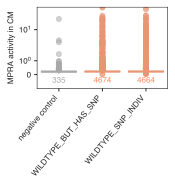

In [24]:
fig = plt.figure(figsize=(2.35, 1.5))
ax = sns.boxplot(data=data, x="type", y="CM", flierprops = dict(marker='o', markersize=5),
                 order=min_ctrl_order, palette=min_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(min_ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity in CM")

for i, label in enumerate(min_ctrl_order):
    n = len(data[data["type"] == label])
    color = min_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 80))
plt.show()
#fig.savefig("Activities_CM.Mital.svg", dpi="figure", bbox_inches="tight")
#plt.close()

## 4. get significant tiles

In [25]:
data["sig"] = data.apply(is_sig, 
                                                                  col="CM_padj",
                                                                  axis=1)
data.sig.value_counts()

not sig    8659
sig        1056
Name: sig, dtype: int64

In [27]:
tots = data.groupby(["type"])["element"].agg("count").reset_index()
sigs = data[data["sig"] == "sig"].groupby(["type"])["element"].agg("count").reset_index()
perc = tots.merge(sigs, on="type", how="left", suffixes=("_tot", "_sig"))
perc.fillna(0, inplace=True)
perc["perc_sig"] = (perc["element_sig"]/perc["element_tot"])*100
print(perc)

                   type  element_tot  element_sig   perc_sig
0   CONTROL_BUT_HAS_SNP           21            8  38.095238
1     CONTROL_SNP_INDIV           21            7  33.333333
2  WILDTYPE_BUT_HAS_SNP         4674          507  10.847240
3    WILDTYPE_SNP_INDIV         4664          503  10.784734
4      negative control          335           31   9.253731


In [28]:
len(data[data['sig']=='sig']['name'].unique())

824

In [29]:
len(data[(data['sig']=='sig')&(data["type"].str.contains("CONTROL"))]['name'].unique())

10

In [31]:
data['full_name'] = data['name'] + '_' + data['type']
data[data['sig']=='sig']

CM       CM_pval       CM_padj  \
1     0.495174  2.070978e-07  3.449617e-06   
8     3.914843  0.000000e+00  0.000000e+00   
9     0.866870  4.579364e-32  1.416248e-30   
11    0.380839  1.297986e-03  1.370081e-02   
18    1.255802  2.347790e-78  1.013306e-76   
...        ...           ...           ...   
9666  0.373897  1.942089e-03  1.985224e-02   
9669  0.579225  2.522203e-11  5.050127e-10   
9699  0.887075  5.938191e-34  1.854205e-32   
9709  0.438970  2.513317e-05  3.439649e-04   
9710  0.723602  2.624765e-20  6.655115e-19   

                                                element             tile_type  \
1     AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...   CONTROL_BUT_HAS_SNP   
8     ACCCCGGTTGGAGAGAGGAGCGGAACTCCTGGACAAGCCCTGACAA...     CONTROL_SNP_INDIV   
9     ACCCCGGTTGGAGAGAGGAGCGGAACTCCTGGACAAGCCCTGACAA...   CONTROL_BUT_HAS_SNP   
11    AGAAGCGCTGAGGAGAGAGGGTTGTAGAGAGGGGAAGAATGGGGAC...   CONTROL_BUT_HAS_SNP   
18    CGTCCAACATGGCTGCCGCGGCGCGTTCGAAGACGCCGCGAACAGG...     CONTROL_SNP_INDIV   
...                                                 ...                   ...   
9666  TTTTGTTTAACAGAGTTCTGTCTTCCCTCTTCTTATGTAAGACATA...    WILDTYPE_SNP_INDIV   
9669  TTTTTCAAGTTTTCCTTTTCATATTTTAGTCTTATGTCAGAAAAAA...  WILDTYPE_BUT_HAS_SNP   
9699  TTTTTTTTTTTGAAAATGCCCCATTTTTCTAAAAGGATAGCCTTCC...  WILDTYPE_BUT_HAS_SNP   
9709  TTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGTCTCGCTCTGTCAC...  WILDTYPE_BUT_HAS_SNP   
9710  TTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGTCTCGCTCTGTCAC...    WILDTYPE_SNP_INDIV   

                                          parse_details  \
1     chr3:171858455:171858590__rs6445040__3:1718585...   
8     chr10:90751035:90751170__rs45465101__10:907511...   
9     chr10:90751035:90751170__rs45465101__10:907511...   
11    chr1:153518242:153518377__rsFakeS100A4-28__1:1...   
18    chr11:72145567:72145702__rs117104239__11:72145...   
...                                                 ...   
9666  chr20:8627574:8627709__rs6055971__20:8627642:C...   
9669  chr3:41817883:41818018__rs7631057__3:41817951:...   
9699  chr3:41914724:41914859__rs17283243__3:41914792...   
9709  chr3:47832111:47832246__rs72906488__3:47832179...   
9710  chr3:47832111:47832246__rs72906488__3:47832179...   

                                                   name  tile_number  chrom  \
1     chr3:171858455:171858590__rs6445040__3:1718585...            1   chr3   
8     chr10:90751035:90751170__rs45465101__10:907511...            1  chr10   
9     chr10:90751035:90751170__rs45465101__10:907511...            1  chr10   
11    chr1:153518242:153518377__rsFakeS100A4-28__1:1...            1   chr1   
18    chr11:72145567:72145702__rs117104239__11:72145...            1  chr11   
...                                                 ...          ...    ...   
9666   chr20:8627574:8627709__rs6055971__20:8627642:C:T            1  chr20   
9669  chr3:41817883:41818018__rs7631057__3:41817951:C:T            1   chr3   
9699  chr3:41914724:41914859__rs17283243__3:41914792...            1   chr3   
9709  chr3:47832111:47832246__rs72906488__3:47832179...            1   chr3   
9710  chr3:47832111:47832246__rs72906488__3:47832179...            1   chr3   

     strand  actual_start  actual_end          snp dupe_info is_snp    CM_log  \
1         +     171858455   171858590         none      4625      0 -0.305242   
8         +      90751035    90751170   rs45465101      4634     68  0.592714   
9         +      90751035    90751170         none      4634      0 -0.062046   
11        +     153518242   153518377         none      4623      0 -0.419258   
18        +      72145567    72145702  rs117104239      4628     68  0.098921   
...     ...           ...         ...          ...       ...    ...       ...   
9666      +       8627574     8627709    rs6055971      2105     68 -0.427248   
9669      +      41817883    41818018         none      3806      0 -0.237153   
9699      +      41914724    41914859         none      4130      0 -0.052040   
9709      +      4

In [32]:
len(data[data['sig']=='sig']['full_name'].unique())

1026

In [89]:
sig_names = data[data['sig']=='sig']['full_name'].unique()
sig_info = data[data['sig']=='sig']

In [90]:
sig_info.to_csv('active_tiles_information.txt', sep='\t')
with open('sig_names.txt', 'w') as f:
    for item in sig_names:
        f.write("%s\n" % item)

In [91]:
with open('sig_names_top100.txt', 'w') as f:
    for item in sig_names[0:100]:
        f.write("%s\n" % item)

No handles with labels found to put in legend.


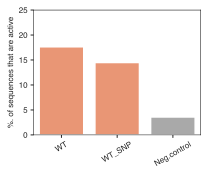

In [41]:
# plot showing active tiles

plt.figure(figsize=(3,2.3))
ax = sns.barplot(data=perc, x="type", y="perc_sig", 
                 ci=None, linewidth=1.5,palette=min_ctrl_pal)
ax.set_xticklabels(['CT','CT_SNP',"WT", "WT_SNP", "Neg.control"], rotation=30)
ax.set_xticklabels(["WT", "WT_SNP", "Neg.control"], rotation=30)



ax.legend().set_visible(False)
plt.ylim((0, 25))
plt.ylabel("%. of sequences that are active", fontsize=fontsize)
plt.xlabel("")
plt.savefig("Perc_sig_sequences.CM.svg", bbox_inches="tight", dpi="figure")

In [34]:
perc

type  element_tot  element_sig   perc_sig
0   CONTROL_BUT_HAS_SNP           21            4  19.047619
1     CONTROL_SNP_INDIV           21            5  23.809524
2  WILDTYPE_BUT_HAS_SNP         4674          265   5.669662
3    WILDTYPE_SNP_INDIV         4664          259   5.553173
4      negative control          335           10   2.985075

## 5. write files

In [33]:
data_file = "%s/CM_vals.significance.txt" % data_dir

In [34]:
data.to_csv(data_file, sep="\t", index=False)